In [45]:
# importing libraries
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the train csv file
file_key = 'fraud_train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
train = train.dropna()
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [46]:
# defining the test csv file
file_key = 'fraud_test.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
test = test.dropna()
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [47]:
# feature 1
train['total_per_trust_level'] = train['grandTotal'] / train['trustLevel']
test['total_per_trust_level'] = test['grandTotal'] / test['trustLevel']

In [48]:
# feature 2
train['interaction_trust_voids'] = train['trustLevel'] * train['lineItemVoids']
test['interaction_trust_voids'] = test['trustLevel'] * test['lineItemVoids']

In [49]:
# feature 3
train['interaction_voids_without_registration'] = train['scansWithoutRegistration'] * train['lineItemVoids']
test['interaction_voids_without_registration'] = test['scansWithoutRegistration'] * test['lineItemVoids']

In [50]:
# feature 4
train['interaction_quantityM_Time'] = train['quantityModifications'] * train['totalScanTimeInSeconds']
test['interaction_quantityM_Time'] = test['quantityModifications'] * test['totalScanTimeInSeconds']

[Text(697.5, 713.475, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(348.75, 509.625, 'scannedLineItemsPerSecond <= 0.015\ngini = 0.392\nsamples = 276\nvalue = [202, 74]'),
 Text(174.375, 305.775, 'interaction_voids_without_registration <= 71.0\ngini = 0.097\nsamples = 117\nvalue = [111, 6]'),
 Text(87.1875, 101.92499999999995, 'gini = 0.053\nsamples = 111\nvalue = [108, 3]'),
 Text(261.5625, 101.92499999999995, 'gini = 0.5\nsamples = 6\nvalue = [3, 3]'),
 Text(523.125, 305.775, 'totalScanTimeInSeconds <= 995.0\ngini = 0.49\nsamples = 159\nvalue = [91, 68]'),
 Text(435.9375, 101.92499999999995, 'gini = 0.381\nsamples = 117\nvalue = [87, 30]'),
 Text(610.3125, 101.92499999999995, 'gini = 0.172\nsamples = 42\nvalue = [4, 38]'),
 Text(1046.25, 509.625, 'total_per_trust_level <= 49.16\ngini = 0.015\nsamples = 1227\nvalue = [1218, 9]'),
 Text(871.875, 305.775, 'trustLevel <= 2.5\ngini = 0.01\nsamples = 1219\nvalue = [1213, 6]'),
 Text(784.6875, 101.92499999999

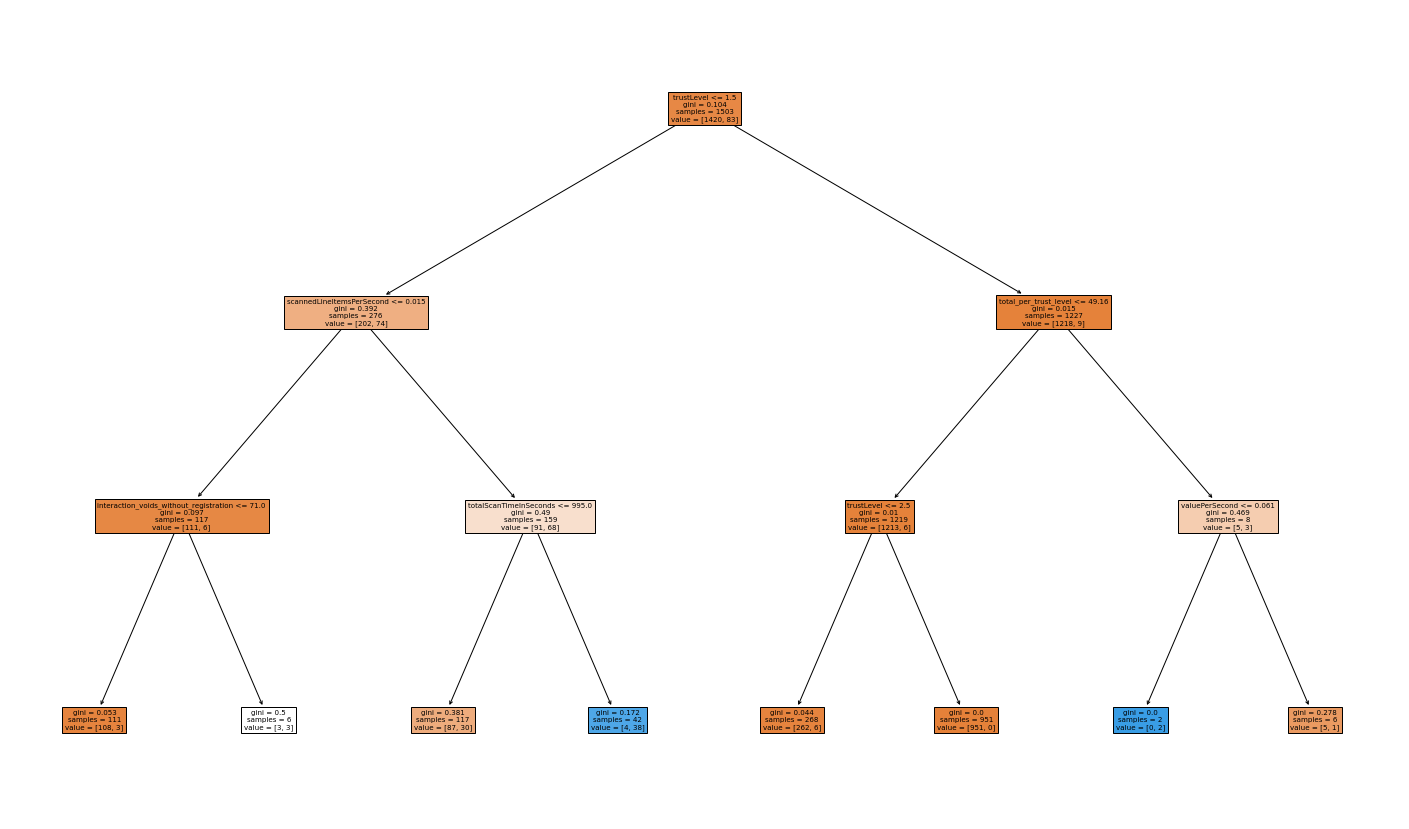

In [51]:
# Creating a plot_tree for feature selection
# defining input and target variables
X = train.drop(columns = ['fraud'], axis = 1)
Y = train['fraud']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# building decision tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# visualizing decision tree results
fig = plt.figure(figsize =(25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [52]:
# feature 5
train['interaction_5'] = np.where((train['trustLevel'] <= 1.5) & (train['total_per_trust_level'] <= 49.573) & (train['trustLevel'] <= 2.5), 1, 0)
test['interaction_5'] = np.where((test['trustLevel'] <= 1.5) & (test['total_per_trust_level'] <= 49.573) & (test['trustLevel'] <= 2.5), 1, 0)

In [53]:
# feature 6
train['interaction_quantity_voids'] = train['quantityModifications'] * train['lineItemVoids']
test['interaction_quantity_voids'] = test['quantityModifications'] * test['lineItemVoids']

In [54]:
# feature 7
train['interaction_value_voids'] = train['valuePerSecond'] * train['lineItemVoids']
test['interaction_value_voids'] = test['valuePerSecond'] * test['lineItemVoids']

In [55]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,total_per_trust_level,interaction_trust_voids,interaction_voids_without_registration,interaction_quantityM_Time,interaction_5,interaction_quantity_voids,interaction_value_voids
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,10.940,35,0,3162,0,21,0.363283
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,9.120,15,10,432,0,20,1.266667
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,20.720,9,30,7580,0,15,0.123008
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,15.385,48,32,7164,0,32,0.412328
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,16.306,15,21,860,0,6,0.568814


In [ ]:
# average importances
importances = []

for i in range(100):
    
    # splitting into training and testing
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # random forest
    RF1 = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
        
    # importances
    importances.append(RF1.feature_importances_)
    
    # printing iteration
    print(f'{i + 1}')

In [57]:
# computing average feature importances 
RF_results = pd.DataFrame(importances)
RF_results = RF_results.apply(np.mean, axis = 0)
RF_results.sort_values(ascending = False)



0     0.278904
9     0.174865
6     0.099440
8     0.081345
10    0.076384
1     0.068397
11    0.048943
7     0.048811
12    0.038015
3     0.034749
2     0.029259
4     0.018473
5     0.002415
dtype: float64

In [59]:
# grabbing columns
print(train.iloc[:, 0])
print(train.iloc[:, 6])
print(train.iloc[:, 8])

# because column 9 is fraud, we can omit that from our importances
## This shows that our most important variables are:
## 1) trustLevel
## 2) scannedLineItemsPerSecond
## 3) lineItemVoidsPerPosition

0       5
1       3
2       3
3       6
4       5
       ..
1874    1
1875    1
1876    4
1877    2
1878    4
Name: trustLevel, Length: 1879, dtype: int64
0       0.027514
1       0.129630
2       0.008575
3       0.016192
4       0.062791
          ...   
1874    0.071651
1875    0.065491
1876    0.094937
1877    0.035036
1878    0.016667
Name: scannedLineItemsPerSecond, Length: 1879, dtype: float64
0       0.241379
1       0.357143
2       0.230769
3       0.275862
4       0.111111
          ...   
1874    0.347826
1875    0.192308
1876    0.166667
1877    0.041667
1878    0.105263
Name: lineItemVoidsPerPosition, Length: 1879, dtype: float64


In [60]:
# feature 9
train['interaction_8'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
test['interaction_8'] = test['trustLevel'] * test['scannedLineItemsPerSecond']

In [61]:
# feature 9
train['interaction_9'] = train['scannedLineItemsPerSecond'] * train['lineItemVoidsPerPosition']
test['interaction_9'] = test['scannedLineItemsPerSecond'] * test['lineItemVoidsPerPosition']

In [62]:
# feature 10
train['interaction_10'] = train['lineItemVoidsPerPosition'] * train['trustLevel']
test['interaction_10'] = test['lineItemVoidsPerPosition'] * test['trustLevel']

[Text(590.1923076923077, 713.475, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(214.6153846153846, 509.625, 'interaction_8 <= 0.012\ngini = 0.394\nsamples = 263\nvalue = [192, 71]'),
 Text(107.3076923076923, 305.775, 'gini = 0.0\nsamples = 78\nvalue = [78, 0]'),
 Text(321.9230769230769, 305.775, 'totalScanTimeInSeconds <= 995.0\ngini = 0.473\nsamples = 185\nvalue = [114, 71]'),
 Text(214.6153846153846, 101.92499999999995, 'gini = 0.312\nsamples = 119\nvalue = [96, 23]'),
 Text(429.2307692307692, 101.92499999999995, 'gini = 0.397\nsamples = 66\nvalue = [18, 48]'),
 Text(965.7692307692307, 509.625, 'total_per_trust_level <= 49.16\ngini = 0.019\nsamples = 1240\nvalue = [1228, 12]'),
 Text(751.1538461538462, 305.775, 'trustLevel <= 2.5\ngini = 0.015\nsamples = 1232\nvalue = [1223, 9]'),
 Text(643.8461538461538, 101.92499999999995, 'gini = 0.065\nsamples = 269\nvalue = [260, 9]'),
 Text(858.4615384615385, 101.92499999999995, 'gini = 0.0\nsamples = 963\nvalue 

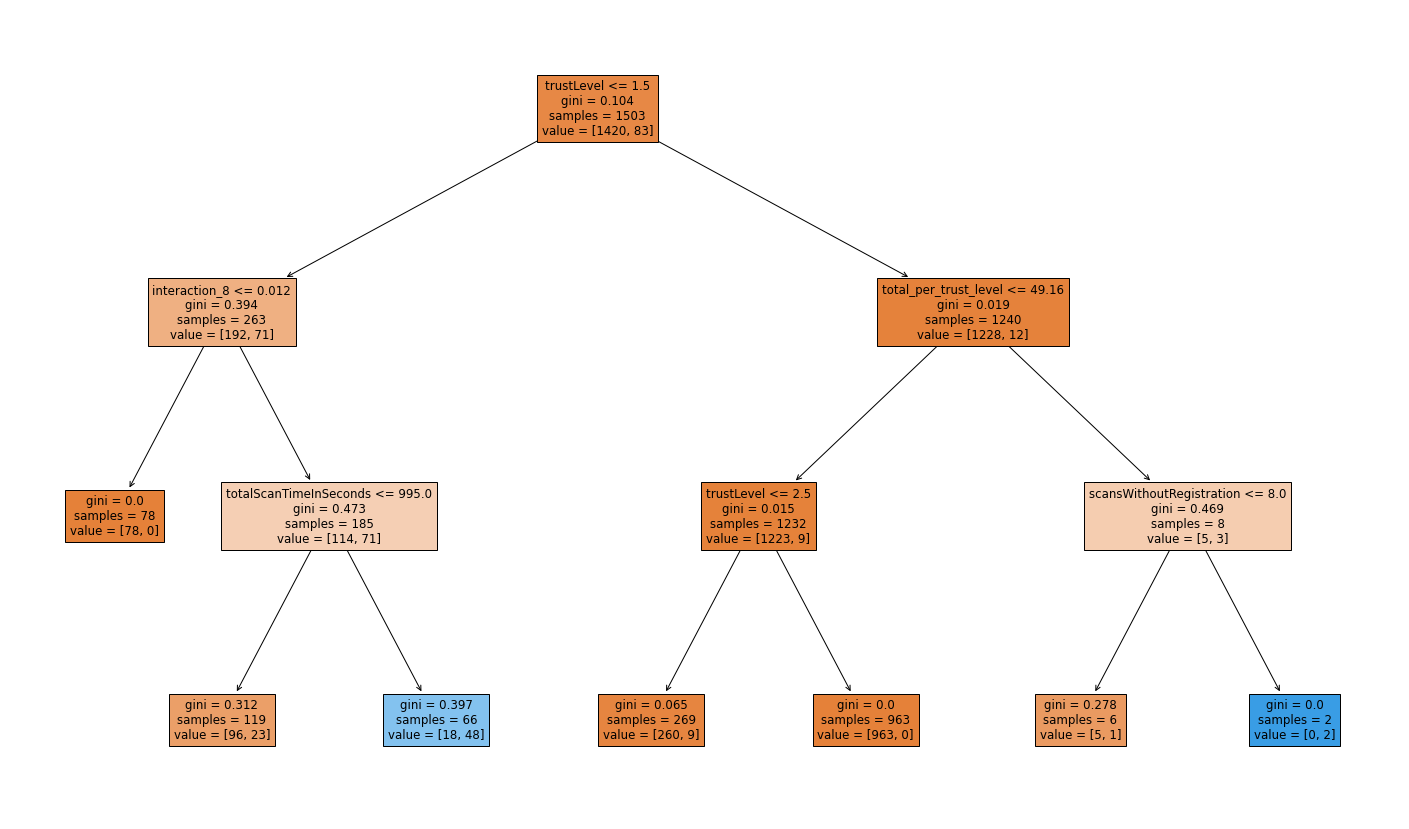

In [63]:
# Creating a plot_tree for feature selection
# defining input and target variables
X = train.drop(columns = ['fraud'], axis = 1)
Y = train['fraud']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# building decision tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# visualizing decision tree results
fig = plt.figure(figsize =(25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [64]:
# interaction 11
# creating a new tree using our previously engineered features
train['interaction_11'] = np.where((train['trustLevel'] <= 1.5) & (train['interaction_8'] <= 0.012) & (train['totalScanTimeInSeconds'] <= 995.0), 1, 0)
test['interaction_11'] = np.where((test['trustLevel'] <= 1.5) & (test['interaction_8'] <= 0.012) & (test['totalScanTimeInSeconds'] <= 995.0), 1, 0)